Group number: CW2 Group 4

Student names and K-numbers:

1. Bhumika Reddy Kurubarahalli Sudharshan (K2463984)
2. Pragati Priya (K2461276)
3. Reghuram Karunamurthi (K2446531)
4. Shreenidhi Dayanand Shetty (K2455943)

In [67]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tcn import TCN
from tensorflow.keras.losses import Huber


In [85]:
file_path = "../starbucks_open_7year.csv"
data = pd.read_csv(file_path)
print(data.isna().sum())


Unnamed: 0    0
Date          0
Open          0
Time          0
dtype: int64


In [86]:
#Data prepration
data["Date"] = pd.to_datetime(data["Date"]) #(Joseph, 2022)
data = data.set_index("Date").sort_index() #sorting by date
data["Log_Open"] = np.log(data["Open"]) #(Numpy, 2024) Log transformation as stock prices exhibit exponential growth (Fama, 1965)
dataa =data["Log_Open"]
data.head()

,Unnamed: 0,Open,Time,Log_Open
Date,,,,
2017-11-13,0,56.81,1.510531e+09,4.039712
2017-11-14,1,56.47,1.510618e+09,4.033710
2017-11-15,2,56.82,1.510704e+09,4.039888
2017-11-16,3,56.92,1.510790e+09,4.041647
2017-11-17,4,57.24,1.510877e+09,4.047253


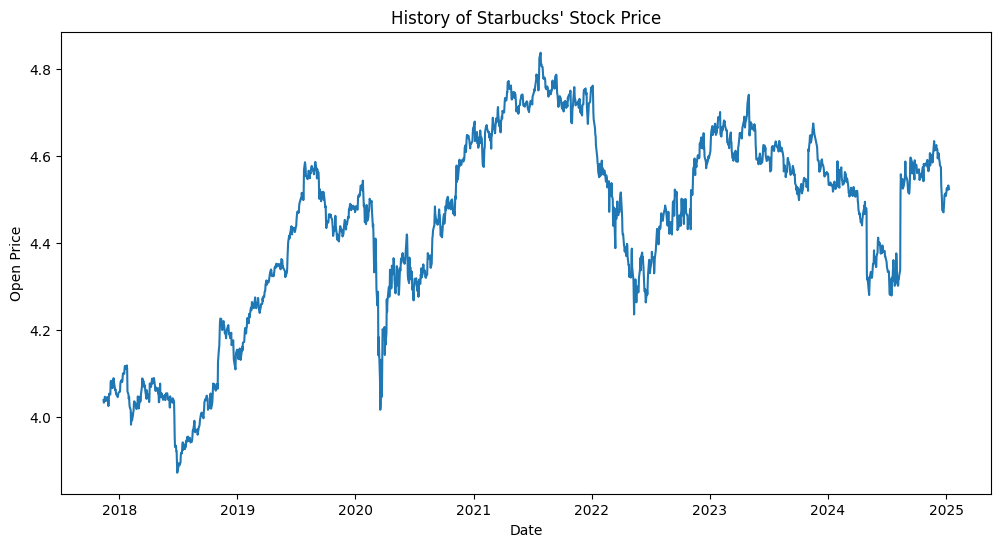

In [84]:
#Visualisation
plt.figure(figsize=(12, 6))
plt.plot(data["Log_Open"])
plt.title("History of Starbucks' Stock Price")
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

Epoch 1/500


c:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1010 - learning_rate: 0.0010
Epoch 2/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0270 - learning_rate: 0.0010
Epoch 3/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0205 - learning_rate: 0.0010
Epoch 4/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0170 - learning_rate: 0.0010
Epoch 5/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - learning_rate: 0.0010
Epoch 6/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0137 - learning_rate: 0.0010
Epoch 7/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0112 - learning_rate: 0.0010
Epoch 8/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - learning_rate: 0.0010
Epoch 9/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0108 - learning_rate: 0.0010
Epoch 10/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0097 - learning_rate: 0.0010
Epoch 11/500
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0095 - learning_rate: 0.0010
Epoch 12/500
90/90 ━

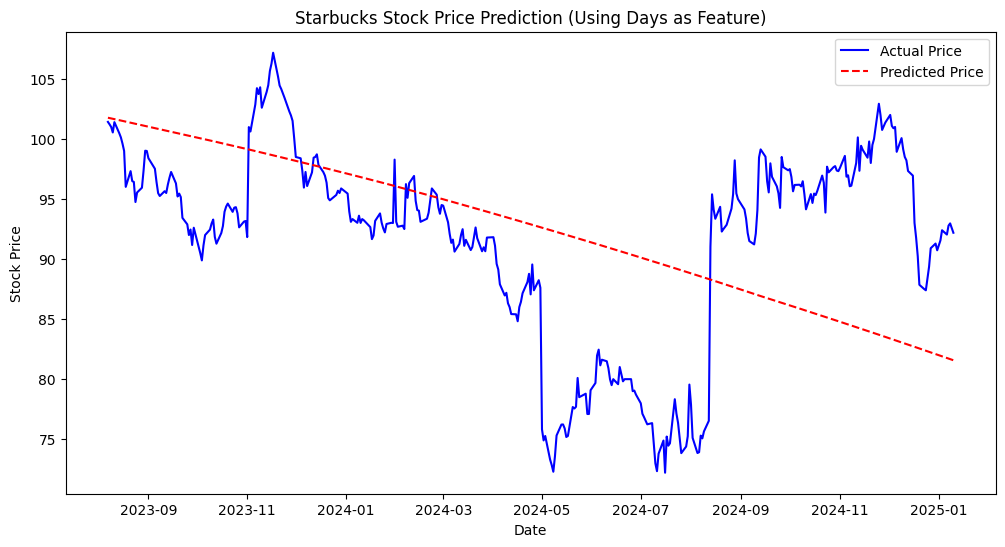

In [ ]:
#model that processes the data independently at each time instance
# Preprocessing the data

data['Days'] = (data.index - data.index.min()).days  
data['Days2'] = data['Days'] ** 2
data['Days3'] = data['Days'] ** 3

# Select features
X = data[['Days', 'Days2', 'Days3']].values.astype(float)
y = data['Open'].values.astype(float)

# Normalization (Min-Max Scaling)
X_min, X_max = X.min(), X.max()
y_min, y_max = y.min(), y.max()

X_normalized = (X - X_min) / (X_max - X_min)
y_normalized = (y - y_min) / (y_max - y_min)

# Splitting Data into Training and Testing Sets
split_index = int(len(X_normalized) * 0.8)
X_train, X_test = X_normalized[:split_index], X_normalized[split_index:]
y_train, y_test = y_normalized[:split_index], y_normalized[split_index:]

# Defining the Model
model = Sequential([
    Dense(512, activation='relu', input_dim=X.shape[1]),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation=LeakyReLU(alpha=0.1)),
    Dense(64, activation='relu'),
    Dense(1)
])

# Train the model
lr_scheduler = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-6)

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=500, batch_size=16, callbacks=[lr_scheduler])

# Make predictions
y_pred_normalized = model.predict(X_test)
# Inverse transform the predictions and actual values
y_pred = y_pred_normalized * (y_max - y_min) + y_min
y_actual = y_test * (y_max - y_min) + y_min

# Compute evaluation metrics
mae = mean_absolute_error(y_actual, y_pred)
mse = mean_squared_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)
mape = (abs((y_actual - y_pred) / y_pred)).mean() * 100

# Print the results
print(f"Model Evaluation Metrics:")
print(f"MAE  (Mean Absolute Error): {mae:.4f}")
print(f"MSE  (Mean Squared Error): {mse:.4f}")
print(f"R² Score (R-squared): {r2:.4f}")
print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[split_index:], y_actual, label='Actual Price', color='blue')
plt.plot(data.index[split_index:], y_pred, label='Predicted Price', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Starbucks Stock Price Prediction (Using Days as Feature)')
plt.legend()
plt.show()


Training Data {(1260, 60, 1)} {(1260,)}
Validation Data {(270, 60, 1)} {(270,)}
Testing Data {(209, 60, 1)} {(209,)}


c:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 80)             │        57,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 50)             │         4,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 30)             │         1,530 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 104,781 (409.30 KB)

 Trainable params: 104,781 (409.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.7147 - val_loss: 0.3791
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3355 - val_loss: 0.2149
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1925 - val_loss: 0.1223
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1092 - val_loss: 0.0691
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0624 - val_loss: 0.0377
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0358 - val_loss: 0.0249
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0224 - val_loss: 0.0166
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0165 - val_loss: 0.0094
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0120 - val_loss: 0.0067
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0101 - val_loss: 0.0063
Epoch 11/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0074 - val_loss: 0.0052
Epoch 12/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

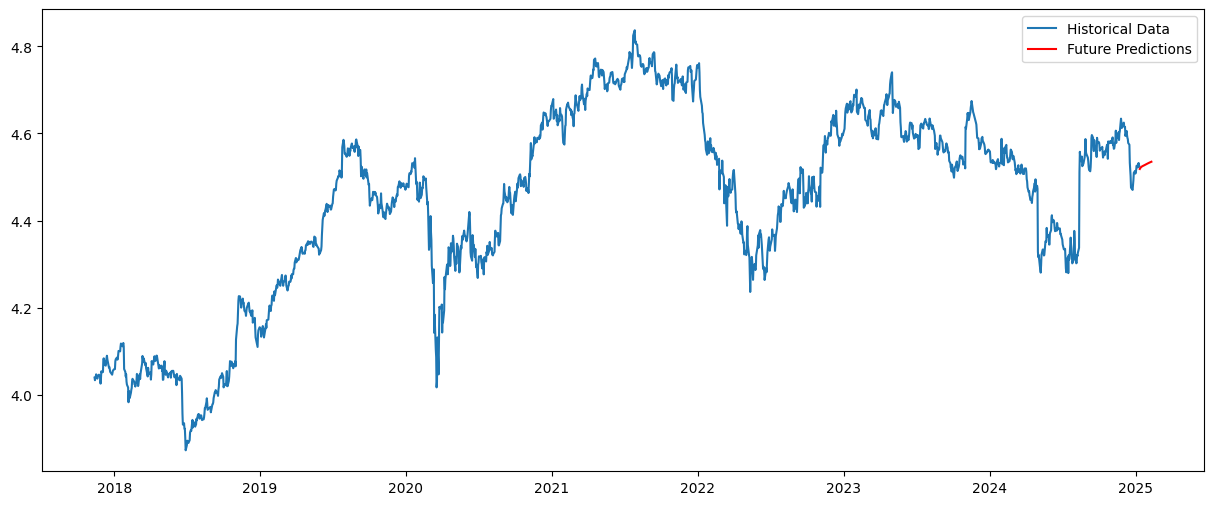

In [73]:
#model that considers data as a timeseries(novel model)
#setting seed for reproducibility (Keras, 2025)
SEED = 44
tf.keras.utils.set_random_seed(SEED)


#Normalising data
scaler = MinMaxScaler(feature_range=(0, 1)) #for faster convergence scaled between 0 and 1 (Jeyaraman, 2024)
scaled_data = scaler.fit_transform(data[["Log_Open"]])

#Adding time series sequence
def create_sequences(data, seq_length):
  X, Y = [], []
  for i in range(len(data)- seq_length-1):
    X.append(data[i:(i+seq_length), 0])
    Y.append(data[i+seq_length,0])
  return np.array(X), np.array(Y)

seq_length = 60 #last 2 months used for prediction
X, Y = create_sequences(scaled_data, seq_length)

#train, validate and test split
train_size = 0.7
validation_size = 0.15
test_size = 0.15

train_end = int(len(scaled_data) * train_size)
val_end = int(len(scaled_data)* (train_size + validation_size))

X_train, Y_train = X[:train_end], Y[:train_end]
X_val, Y_val = X[train_end:val_end], Y[train_end:val_end]
X_test, Y_test = X[val_end:], Y[val_end:]

#Reshaping for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print ("Training Data", {X_train.shape}, {Y_train.shape})
print ("Validation Data", {X_val.shape}, {Y_val.shape})
print ("Testing Data", {X_test.shape}, {Y_test.shape})

#Creating a novel neural network using LSTM layers fro time series forecasting
def novel_model(seq_length):
  model = Sequential()
  model.add(LSTM(100, activation="relu", return_sequences=True, recurrent_dropout=0.2, input_shape=(seq_length, 1)))
  model.add(Dropout(0.2))

  #Second layer
  model.add(LSTM(80,activation ="relu"))
  model.add(Dropout(0.3))

  #Dense layers to further compress the output (gradual reduction)
  model.add(Dense(50, activation="relu", kernel_regularizer=l2(0.01)))
  model.add(Dense(30, activation="relu"))
  model.add(Dense(15, activation="relu"))

  #Output layer
  model.add(Dense(1))
  model.compile(optimizer="adam", loss="mean_squared_error")
  return model

model = novel_model(seq_length)
model.summary()

#Fitting and training the model
early_stop = EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True) #Early stopping to prevent overfitting and stopping the model from memorising training data instead of learning general patterns

history= model.fit(X_train, Y_train, epochs=100,
                   batch_size=32, validation_data=(X_val, Y_val),
                   callbacks=[early_stop],
                   verbose=1
                   )

#Comparing losses
train_loss = model.evaluate(X_train, Y_train)
val_loss = model.evaluate(X_val, Y_val)
test_loss = model.evaluate(X_test, Y_test)

print("Comparing Losses:")
print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")

#Evaluating scaled data
Y_pred = model.predict(X_test)
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
r2= r2_score(Y_test, Y_pred)
mape = mean_absolute_percentage_error(Y_test, Y_pred)

print("Model performance on scaled data:")
print(f"MAE:{mae:.4f}")
print(f"MSE:{mse:.4f}")
print(f"RMSE:{rmse:.4f}")
print(f"R2 Score:{r2:4f}")
print(f"MAPE:{mape:.4f}")

#Evaluating actual price predictions
train_predict = model.predict(X_train)
val_predict = model.predict(X_val)
test_predict = model.predict(X_test)

#Inversing prediction from vector to actual price to test scores
train_predict = scaler.inverse_transform(train_predict)
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1,1))
val_predict = scaler.inverse_transform(val_predict)
Y_val_actual = scaler.inverse_transform(Y_val.reshape(-1,1))
test_predict = scaler.inverse_transform(test_predict)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1,1))

mae_actual = mean_absolute_error(Y_test_actual, test_predict)
mse_actual = mean_squared_error(Y_test_actual, test_predict)
rmse_actual = np.sqrt(mse_actual)
r2 = r2_score(Y_test_actual, test_predict)
mape = mean_absolute_percentage_error(Y_test_actual, test_predict)

print("Model performance on actual price prediction:")
print(f"MAE: {mae_actual:.4f}")
print(f"MSE: {mse_actual:.4f}")
print(f"RMSE: {rmse_actual:.4f}")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")


#Code for actual prediction
def predict_stock(model, end_sequence, future_days):
  predictions = []
  current_sequence = end_sequence.copy()

  for i in range(future_days):
    current_input = current_sequence.reshape((1, seq_length,1))
    new_prediction = model.predict(current_input)[0,0]
    predictions.append(new_prediction)

    current_sequence = np.roll(current_sequence,-1)
    current_sequence[-1] = new_prediction
  return scaler.inverse_transform(np.array(predictions).reshape(-1,1))

end_sequence = scaled_data[-seq_length:]
future_predictions = predict_stock(model, end_sequence, 30)

#Ploting future predicitons
plt.figure(figsize=(15, 6))
plt.plot(data.index,data["Log_Open"], label="Historical Data")
future_dates = pd.date_range(start=data.index[-1], periods=31, freq="D")[1:]
plt.plot(future_dates, future_predictions, "r-", label="Future Predictions")
plt.legend()
plt.show()

Training Data: (1019, 60, 1) (1019,)
Validation Data: (299, 60, 1) (299,)
Testing Data: (299, 60, 1) (299,)
Epoch 1/100


C:\Users\Bhumika Reddy\AppData\Local\Temp\ipykernel_23036\3783359256.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
c:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\venv\Lib\site-packages\tcn\tcn.py:263: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(TCN, self).__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 8.0310e-04 - loss: 4.3257 - val_accuracy: 0.0000e+00 - val_loss: 0.0046 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 8.0310e-04 - loss: 0.1071 - val_accuracy: 0.0000e+00 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 8.0310e-04 - loss: 0.0306 - val_accuracy: 0.0000e+00 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 8.0310e-04 - loss: 0.0189 - val_accuracy: 0.0000e+00 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 8.0310e-04 - loss: 0.0115 - val_accuracy: 0.0000e+00 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 8.0310e-04 - loss: 0.0091 - val_accuracy: 0.0000e+00 - val_loss: 2.3744e-04 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/s

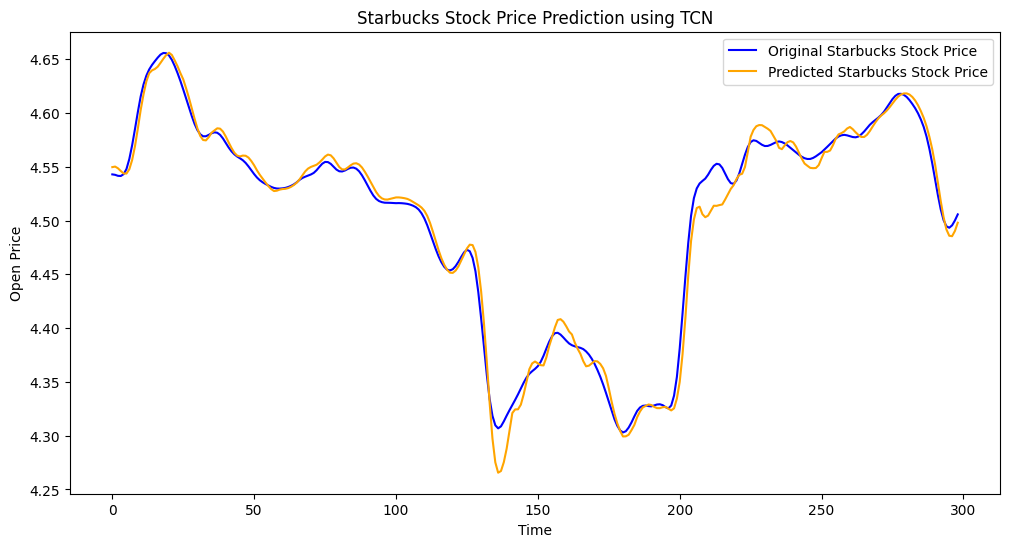

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

In [76]:
#model that considers data as a timeseries(existing model)
#setting seed for reproducibility (Keras, 2025)
SEED = 44
tf.keras.utils.set_random_seed(SEED)
#checking for missing data
data.fillna(method='ffill', inplace=True)
#smoothning the data using a moving average
data['Log_Open'] = data['Log_Open'].rolling(window=5).mean().fillna(data['Log_Open'])
#scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Log_Open']])
#creating sequence
time_step=60
def create_sequences(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step-1):
        X.append(data[i:(i + time_step),0])
        Y.append(data[i + time_step,0])
    return np.array(X), np.array(Y)
X, Y = create_sequences(scaled_data, time_step)

#split data into train validate and test
train_size = 0.6 
validation_size = 0.2  
test_size = 0.2 

#split the data into training,validation and testing
train_size = int(len(scaled_data) * train_size)
validation_size = int(len(scaled_data) * validation_size)
test_size = len(scaled_data) - (train_size + validation_size)

# Split the data into training, validation, and test sets
train_data = scaled_data[:train_size]
validation_data = scaled_data[train_size:train_size + validation_size]
test_data = scaled_data[train_size + validation_size:]
#creating sequences
X_train, Y_train = create_sequences(train_data, time_step)
X_val, Y_val = create_sequences(validation_data, time_step)
X_test, Y_test = create_sequences(test_data, time_step)
#reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Print the shapes of the data sets
print("Training Data:", X_train.shape, Y_train.shape)
print("Validation Data:", X_val.shape, Y_val.shape)
print("Testing Data:", X_test.shape, Y_test.shape)
#tcn model

model = Sequential()
model.add(TCN(input_shape=(X_train.shape[1], 1),nb_filters=128,kernel_size=3,nb_stacks=1,dilations=[1,2,4,8,16]))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss=Huber(), metrics=['accuracy'])

#train the model
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

lr_scheduler=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-4,verbose=1)

model.fit(X_train,Y_train,
          epochs=100,
          batch_size=32,
          validation_data=(X_val, Y_val),
          callbacks=[lr_scheduler])


#evaluation on scaled data
y_pred = model.predict(X_test)

mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
mape = mean_absolute_percentage_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)

print(f"Scaled MAE: {mae:.4f}")
print(f"Scaled MSE: {mse:.4f}")
print(f"Scaled MAPE: {mape:.4f}")
print(f"Scaled R2 Score: {r2:.4f}")

#evaluating actual price predictions

y_pred_actual = scaler.inverse_transform(y_pred)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))
mae_actual = mean_absolute_error(Y_test_actual, y_pred_actual)
mse_actual = mean_squared_error(Y_test_actual, y_pred_actual)
mape_actual = mean_absolute_percentage_error(Y_test_actual, y_pred_actual)
print(f'Actual MAE: {mae_actual:.4f}')
print(f'Actual MSE: {mse_actual:.4f}')
print(f'Actual MAPE: {mape_actual:.4f}')


plt.figure(figsize=(12,6))
plt.plot(Y_test_actual, label='Original Starbucks Stock Price', color='blue')
plt.plot(y_pred_actual, label='Predicted Starbucks Stock Price', color='orange')
plt.title('Starbucks Stock Price Prediction using TCN')
plt.xlabel('Time')
plt.ylabel('Open Price')
plt.legend()
plt.show()

#actual prediction
def predict_stock(model, last_sequence, future_days):
  predictions = []
  current_sequence = last_sequence.copy()

  for i in range(future_days):
    current_input = current_sequence.reshape((1, time_step,1))
    next_prediction = model.predict(current_input)[0,0]
    predictions.append(next_prediction)

    current_sequence = np.roll(current_sequence,-1)
    current_sequence[-1] = next_prediction
  return scaler.inverse_transform(np.array(predictions).reshape(-1,1))

last_sequence = scaled_data[-time_step:]
future_predictions = predict_stock(model, last_sequence, 30)


Epoch 1/200


c:\Users\Bhumika Reddy\OneDrive\Desktop\dl-group-project\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5491 - mae: 0.4377 - val_loss: 0.4676 - val_mae: 0.5242 - learning_rate: 5.0000e-04
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2905 - mae: 0.2512 - val_loss: 0.4157 - val_mae: 0.4939 - learning_rate: 5.0000e-04
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2423 - mae: 0.2151 - val_loss: 0.3414 - val_mae: 0.4292 - learning_rate: 5.0000e-04
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2113 - mae: 0.1860 - val_loss: 0.2700 - val_mae: 0.3495 - learning_rate: 5.0000e-04
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1898 - mae: 0.1667 - val_loss: 0.2245 - val_mae: 0.2886 - learning_rate: 5.0000e-04
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1820 - mae: 0.1632 - val_loss: 0.1973 - val_mae: 0.2476 - learning_rate: 5.0000e-04
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1658 - mae: 0.1408 - val_loss: 0.1697 - val_mae: 0.1945 - learning_rate: 5.0000e-

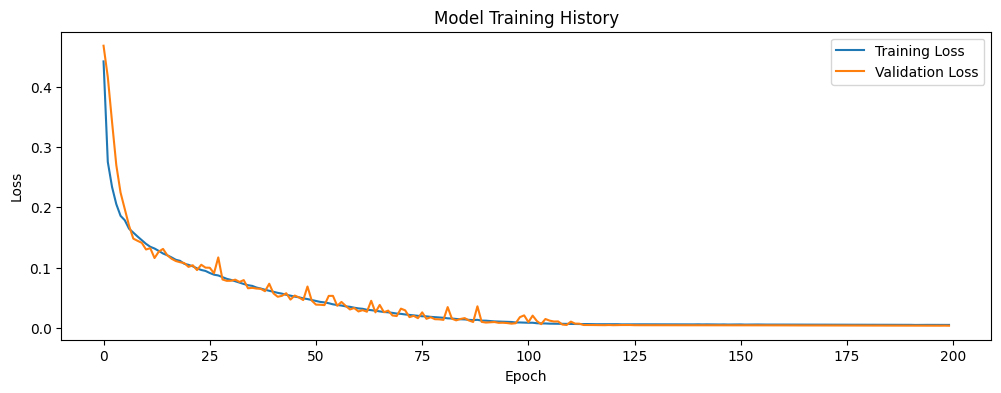

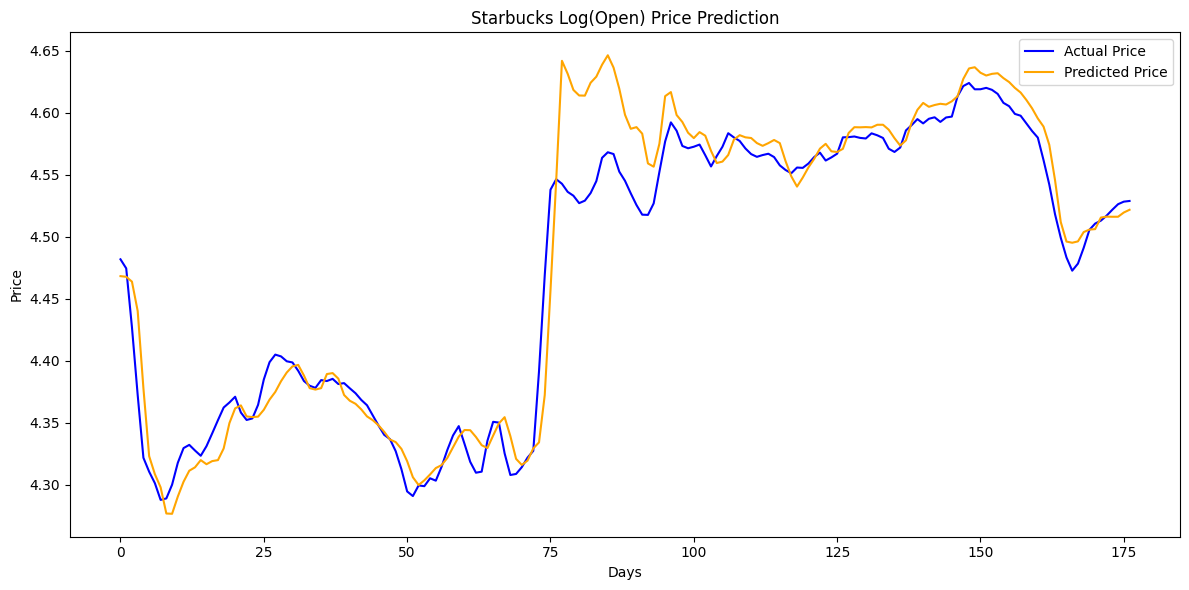

In [87]:
#one deep network, to approach the task as a regression problem
#Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
# Data Preprocessing
data.ffill(inplace=True)
data['Log_Open'] = np.log(data['Open'])

# Smooth the data using a rolling window
data['Smoothed_Log_Open'] = data['Log_Open'].rolling(window=3).mean().fillna(data['Log_Open'])


# Scaling the data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[['Smoothed_Log_Open']])

# Creating lag features
def create_lag_features(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i - window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_lag_features(scaled, window=30)

# Train, Validation, Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Reshaping the data
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Building the DNN model (Regression Model)
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_flat.shape[1],), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Training the model
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = model.fit(
    X_train_flat, y_train,
    validation_data=(X_val_flat, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

y_pred_scaled = model.predict(X_test_flat)

# Scaled prediction metrics
metrics = {
    'MAE': mean_absolute_error(y_test, y_pred_scaled),
    'MSE': mean_squared_error(y_test, y_pred_scaled),
    'R²': r2_score(y_test, y_pred_scaled),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred_scaled)
}

print("\n[Scaled Evaluation]")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Actual predictions (inverse scaling)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Inverse scaled prediction metrics
inv_metrics = {
    'MAE': mean_absolute_error(y_test_actual, y_pred_actual),
    'MSE': mean_squared_error(y_test_actual, y_pred_actual),
    'R²': r2_score(y_test_actual, y_pred_actual),
    'MAPE': mean_absolute_percentage_error(y_test_actual, y_pred_actual)
}

print("\n[Inverse Scaled Evaluation]")
for metric, value in inv_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Actual vs Predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Price', color='blue')
plt.plot(y_pred_actual, label='Predicted Price', color='orange')
plt.title('Starbucks Log(Open) Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()


